In [ ]:
# To access via colab
import sys, os
if 'google.colab' in sys.modules:

    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = 'My Drive/5153: Applied Machine Learning/wsb data/combined data'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)

Requires runtime restart

In [ ]:
pip install lazypredict

In [ ]:
pip install umap-learn

In [ ]:
!pip install texthero==1.1.0 -q
!pip install demoji

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import demoji

pd.set_option('display.max_colwidth', 50)

%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

ModuleNotFoundError: ignored

In [ ]:
!pip install texthero==1.1.0 -q
!pip install demoji
import texthero as hero

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import demoji
import texthero as hero
from texthero import stopwords

pd.set_option('display.max_colwidth', 50)

%matplotlib inline

In [ ]:
# Unzip file from Gdrive
#!unzip combined_comments.csv.zip
df = pd.read_csv('/content/combined_comments.csv')

In [ ]:
# Unzip in colab
#df = pd.read_csv('./combined_data/combined_comments.csv', sep = ',')
df=df.reset_index()

## 1. Text Preprocessing

In [ ]:
# Filter out comments w
print('Length of df before removal of dead comments: {}'.format(len(df)))
df = df[~(df['body'] == '[removed]')]
print('Length of df after removal of dead comments: {}'.format(len(df)))

Length of df before removal of dead comments: 1092980
Length of df after removal of dead comments: 810189


In [ ]:
def find_pos(word):
    # Part of Speech constants
    # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    pos= nltk.pos_tag(nltk.word_tokenize(word))[0][1]
    # Adjective tags -'JJ', 'JJR', 'JJS'
    if pos.lower()[0] == 'j':
        return 'a'
    # Adverb tags -'RB', 'RBR', 'RBS'
    elif pos.lower()[0] == 'r':
        return 'r'
    # Verb tags -'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
    elif pos.lower()[0] == 'v':
        return 'v'
    # Noun tags -'NN', 'NNS', 'NNP', 'NNPS'
    else:
        return 'n'

demoji.download_codes()

def remove_emoji(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, ':'+ dem[item].replace(" ", "")+':'+' ') # replace with emoji mapping and additional space
        
    return text

# Function to apply lemmatization to a list of words
def words_lemmatizer(text, encoding="utf8"):
    words = nltk.word_tokenize(text)
    lemma_words = []
    wl= WordNetLemmatizer()
    for word in words:
        pos= find_pos(word)
        lemma_words.append(wl.lemmatize(word, pos))
    return " ".join(lemma_words)

def do_preprocessing(df_series):
    custom_pipeline = [hero.preprocessing.fillna, #remove NA
                          hero.preprocessing.lowercase, # lowercase
                          hero.preprocessing.remove_urls,
                          hero.preprocessing.remove_digits, # remove numbers
                          hero.preprocessing.remove_punctuation # remove punctuation
                          ] 
    df_series = df_series.pipe(hero.clean, custom_pipeline)

    df_series = df_series.apply(remove_emoji) # Remove emojis

     # add custom stopwords
    default_stopwords = stopwords.DEFAULT
    new_words = ['already','also','comment','delete','even','literally','lolol','lololol','lolz','lols','lot','loll','lolololol','lolll','mean','na',
                'point','post','probably','put','reddit','remove','see','something','want','well']
    custom_stopwords = default_stopwords.union(set(new_words))
    df_series = hero.preprocessing.remove_stopwords(df_series, custom_stopwords) # remove stopwords
    lemmatize_text = df_series.apply(words_lemmatizer)
    
    df_series = hero.preprocessing.remove_whitespace(df_series) # remove redundant whitespace as the last step
    
    return df_series

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


In [ ]:
print('Test function, inspect "BEFORE"')
df['body'][10:15]

Test function, inspect "BEFORE"


20                                     Ps I am retarded
21    Finally convinced my wife's boyfriend to let m...
22                                  AMC 💎👐💎👐🚀🚀🚀🚀🚀🛰️🛰️🛰️
23                                          And my axe!
25    Should  invest in AMC tomorrow or did the bull...
Name: body, dtype: object

In [ ]:
print('Test function, inspect "AFTER"')
do_preprocessing(df['body'][10:15])

Test function, inspect "AFTER"


20                                          ps retarded
21    finally convinced wife boyfriend let gambling ...
22    amc :gemstone: :openhands: :gemstone: :openhan...
23                                                  axe
25              invest amc tomorrow bullshit today ruin
Name: body, dtype: object

In [ ]:
# # Preprocessing
# # change to string
# df['body'] = df['body'].astype(str)
# df['body'] = do_preprocessing(df['body'])

In [ ]:
# df.to_csv('text_preprocessed.csv')

## 2. Exploratory Data Analysis

In [ ]:
df_all = pd.read_csv('/content/text_preprocessed.csv')
df_lab = pd.read_csv('/content/tags_only.csv')
df = df_lab.merge(df_all, how = 'inner', on = 'id') # join labels to the preprocessed comments

In [ ]:
# Convert to string
df_all['body'] = df_all['body'].astype(str)
df['body'] = df['body'].astype(str)
df['body'][0:5]
df

### Create Dictionary to Inspect Words

In [ ]:
# # Create dictionary from ALL COMMENTS
# processed = df_all['body'].apply(str.split)

# # Create a complete corpus from list of texts

# # Split corpus into list of words
# words = []
# for i in processed:
#   words += i

# # Create dictionary
# from collections import Counter
# my_counter = Counter(words)

# # Send to df and export to csv
# counts_df = pd.DataFrame.from_dict(my_counter, orient='index').reset_index()
# counts_df.to_csv('processed/dictionary.csv')

### Create Word Cloud to Inspect Words

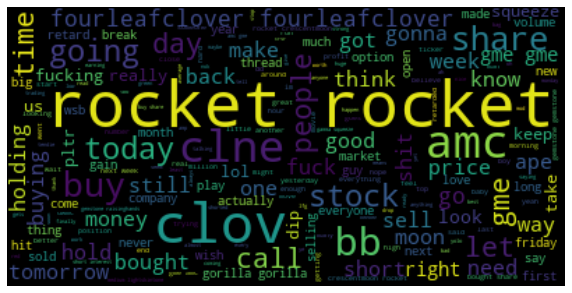

In [ ]:
#word cloud for all posts

stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
textt = " ".join(text for text in df['body'])
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud11.png')
plt.show()

[-4, -9]

In [ ]:
# split df - positive and negative sentiment:
positive = df[df['sentiment'] == 1]
neutral1 = df[df['sentiment'] == 0] 
neutral2 = df[df['sentiment'] == -1]
#negative = df[df['sentiment'] == -1]

In [ ]:
frames = [neutral1, neutral2]
neutral = pd.concat(frames)
#dfcombined

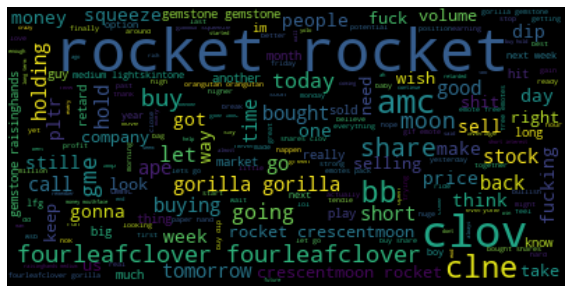

In [ ]:
#wordcloud for positive sentiment posts only

stopwords = set(STOPWORDS)
stopwords.update(["br", "href"]) 
pos = " ".join(review for review in positive['body']) 
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

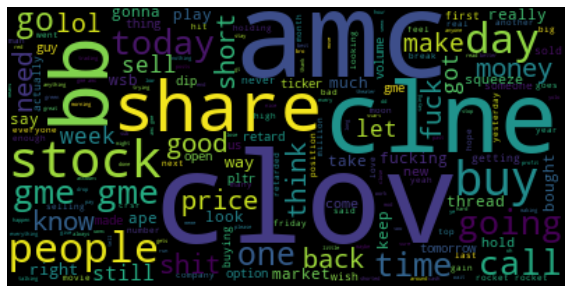

In [ ]:
#wordcloud for neutral posts
neu = " ".join(review for review in neutral['body'])
wordcloud3 = WordCloud(stopwords=stopwords).generate(neu)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud33.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [ ]:
# split df - positive and negative sentiment:
positives = df[df['sentiment'] == 1]
neutrals1 = df[df['sentiment'] == 0] 
neutrals2 = df[df['sentiment'] == -1]
#negative = df[df['sentiment'] == -1]

In [ ]:
frames = [neutrals1, neutrals2]
neutrals = pd.concat(frames)
#dfcombined

In [ ]:
neutrals['sentiment']=0

In [ ]:
frames2 = [positives, neutrals]
df=pd.concat(frames2)

In [ ]:
df['sentiment'].value_counts()

0    2999
1    2490
Name: sentiment, dtype: int64

In [ ]:
from nltk.corpus import stopwords

#create new df with only body and sentiment
dfNew = df[['body','sentiment']]

# create sparse matrix with 1-gram and 2-gram
stop = set(stopwords.words('english'))
corpus = dfNew.loc[:,'body']
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop))
vectorized = tfidf.fit_transform(corpus)
#print(vectorized)

#convert to dense matrix
vocab = tfidf.get_feature_names()
#print(vocab)
df_vectorized= pd.DataFrame(vectorized.todense(),columns=vocab)
#df_vectorized

# combine with dfNew

df_combined = pd.concat([dfNew, df_vectorized], axis=1)
df_combined

,body,sentiment,000x,000x make,00pm,00pm bring,01on,01on friday,0s,0s gme,...,zjz think,zone,zone amc,zone keeps,zone love,zoo,zoo morning,zoom,zoom next,zoppity
0,thanks lost look amcs business page :manshrugg...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,awesome :smilingfacewithsunglasses: moon :thin...,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,look amcs business page find actually business...,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,bought today retarded dumb money ape germany d...,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,ahh fellow retard people getting pessimistic g...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5484,holding bb shares hit moon,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5485,b ippity b oppity give zoppity,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5486,lol really forcing bb thing eh,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5487,:gemstone: :gemstone: :gemstone: :gorilla: :go...,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
X=df_combined.drop(['body','sentiment'],axis=1)
y=df_combined['sentiment']

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(X)
principalComponents

array([[ 0.02593925, -0.01043091,  0.02755191, ..., -0.0061049 ,
        -0.00373149,  0.00488846],
       [ 0.00916394, -0.01275899, -0.00049808, ..., -0.03492587,
        -0.01048496, -0.00668709],
       [-0.03901794, -0.01089237, -0.00966782, ..., -0.05377423,
        -0.00522375,  0.02552091],
       ...,
       [-0.03577818, -0.01853886,  0.0153794 , ...,  0.00610493,
        -0.00580186,  0.05956033],
       [-0.03711287, -0.01089771, -0.00568132, ..., -0.00031786,
         0.00653632, -0.00949438],
       [-0.03701441, -0.03326741,  0.07379193, ...,  0.01418101,
         0.00192616, -0.021701  ]])

In [ ]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.01917415 0.0045352  0.00321143 0.00285779 0.0028015  0.0026066
 0.00224975 0.00214102 0.0021269  0.00207439 0.00200549 0.00184122
 0.00174602 0.00166194 0.0016154  0.00156137 0.00152462 0.00150045
 0.00147275 0.00144623 0.00143519 0.00138436 0.00133688 0.0013285
 0.00130539 0.00129507 0.00126831 0.00126146 0.00123523 0.00121461
 0.00119943 0.00119093 0.00117214 0.00115352 0.00113233 0.00112424
 0.00111264 0.00108564 0.00106647 0.00105823 0.00105386 0.00104262
 0.0010255  0.0010226  0.00100482 0.00099491 0.00098357 0.00096271
 0.00095831 0.00095613 0.00094837 0.00094336 0.00093881 0.00093085
 0.00091852 0.00091357 0.00090811 0.00089748 0.0008808  0.00087667
 0.00086959 0.00086594 0.00085395 0.00084098 0.00083107 0.00082351
 0.00081236 0.00080998 0.00080598 0.00080091 0.00079475 0.00079085
 0.00078874 0.00077619 0.00077407 0.00076772 0.00076464 0.0007608
 0.00075877 0.00075289 0.0007449  0.00074058 0.00073193 0.00073036
 0.00072197 0.000717

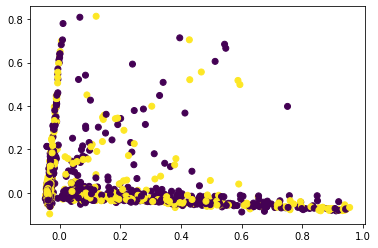

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(principalComponents[:,0], principalComponents[:,1],c=y.iloc[:,0])
plt.show()

In [ ]:
n_neighbors=5
min_dist=0.1
n_components=100
metric='euclidean'

fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
u = fit.fit_transform(X)
u

array([[9.413101 , 9.821444 , 7.155732 , ..., 3.6838472, 4.61359  ,
        5.3709235],
       [9.389803 , 9.780692 , 7.0641747, ..., 3.6834261, 4.641656 ,
        5.3350396],
       [9.300209 , 9.739069 , 5.202341 , ..., 3.5020006, 4.7392187,
        4.9476285],
       ...,
       [9.417623 , 9.834188 , 4.7208834, ..., 3.772889 , 4.4571004,
        4.8538246],
       [9.2860775, 9.631302 , 5.193669 , ..., 3.7024412, 4.526812 ,
        5.12311  ],
       [9.465763 , 9.97044  , 5.7517395, ..., 3.6844728, 4.5966387,
        4.9224524]], dtype=float32)

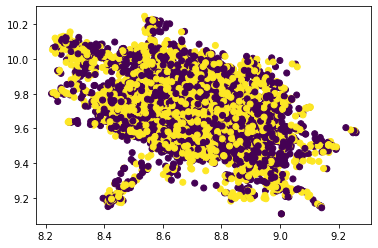

In [ ]:
plt.scatter(u[:,3], u[:,7],c=y.iloc[:,0])

In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X=df_combined.drop(['body','sentiment'],axis=1)
y=df_combined['sentiment']
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y, test_size = 0.30)

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(X_train, X_test, y_train.iloc[:,0], y_test.iloc[:,0])


100%|██████████| 29/29 [00:49<00:00,  1.70s/it]


In [ ]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.56               0.54     0.54      0.55   
NuSVC                              0.55               0.54     0.54      0.55   
NearestCentroid                    0.54               0.54     0.54      0.54   
GaussianNB                         0.53               0.54     0.54      0.52   
LogisticRegression                 0.55               0.53     0.53      0.54   
BernoulliNB                        0.55               0.53     0.53      0.54   
LinearDiscriminantAnalysis         0.55               0.53     0.53      0.53   
RidgeClassifierCV                  0.55               0.53     0.53      0.53   
RidgeClassifier                    0.55               0.53     0.53      0.53   
PassiveAggressiveClassifier        0.52               0.53     0.53      0.52   
LinearSVC                   

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(u, y, test_size = 0.30)

In [ ]:
clfu = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric = None)
modelsu,predictionsu = clfu.fit(X_train, X_test, y_train.iloc[:,0], y_test.iloc[:,0])


  3%|▎         | 1/29 [00:02<01:17,  2.76s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.5701275045537341, 'Balanced Accuracy': 0.5522259304508478, 'ROC AUC': 0.5522259304508477, 'F1 Score': 0.556267956398188, 'Time taken': 2.7588164806365967}


  7%|▋         | 2/29 [00:06<01:26,  3.21s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.581056466302368, 'Balanced Accuracy': 0.5633928305372627, 'ROC AUC': 0.5633928305372627, 'F1 Score': 0.5677521493010099, 'Time taken': 3.5163259506225586}
{'Model': 'BernoulliNB', 'Accuracy': 0.5749848208864602, 'Balanced Accuracy': 0.5729334902708663, 'ROC AUC': 0.5729334902708663, 'F1 Score': 0.5757576135932041, 'Time taken': 0.05760025978088379}


 14%|█▍        | 4/29 [00:12<01:14,  2.99s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.5822707953855495, 'Balanced Accuracy': 0.5555380076879526, 'ROC AUC': 0.5555380076879526, 'F1 Score': 0.5497223393222308, 'Time taken': 5.669675827026367}


 21%|██        | 6/29 [00:12<00:40,  1.75s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.525197328476017, 'Balanced Accuracy': 0.521011502130576, 'ROC AUC': 0.521011502130576, 'F1 Score': 0.5255258036023418, 'Time taken': 0.6645698547363281}
{'Model': 'DummyClassifier', 'Accuracy': 0.49666059502125076, 'Balanced Accuracy': 0.4924893471199976, 'ROC AUC': 0.49248934711999764, 'F1 Score': 0.497137718990092, 'Time taken': 0.03962349891662598}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.533090467516697, 'Balanced Accuracy': 0.529546470395423, 'ROC AUC': 0.529546470395423, 'F1 Score': 0.5336223845642254, 'Time taken': 0.0434422492980957}


 31%|███       | 9/29 [00:13<00:21,  1.07s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.5628415300546448, 'Balanced Accuracy': 0.5509602491135016, 'ROC AUC': 0.5509602491135015, 'F1 Score': 0.5572544932161361, 'Time taken': 1.0943031311035156}
{'Model': 'GaussianNB', 'Accuracy': 0.573163327261688, 'Balanced Accuracy': 0.5648104830298877, 'ROC AUC': 0.5648104830298877, 'F1 Score': 0.5708379362553868, 'Time taken': 0.04239368438720703}


 38%|███▊      | 11/29 [00:14<00:15,  1.16it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.5573770491803278, 'Balanced Accuracy': 0.5453767990702941, 'ROC AUC': 0.5453767990702941, 'F1 Score': 0.55165097533616, 'Time taken': 0.8174717426300049}


 41%|████▏     | 12/29 [00:16<00:17,  1.01s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.5428051001821493, 'Balanced Accuracy': 0.5294093983730147, 'ROC AUC': 0.5294093983730147, 'F1 Score': 0.5353799270822921, 'Time taken': 1.640960454940796}


 48%|████▊     | 14/29 [00:18<00:14,  1.01it/s]

{'Model': 'LabelSpreading', 'Accuracy': 0.5434122647237402, 'Balanced Accuracy': 0.5298362585297536, 'ROC AUC': 0.5298362585297536, 'F1 Score': 0.5357572487488044, 'Time taken': 2.053173542022705}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.5798421372191864, 'Balanced Accuracy': 0.5642808188563426, 'ROC AUC': 0.5642808188563426, 'F1 Score': 0.5697182809930891, 'Time taken': 0.1974809169769287}


 52%|█████▏    | 15/29 [00:20<00:15,  1.09s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.575591985428051, 'Balanced Accuracy': 0.5569385261777765, 'ROC AUC': 0.5569385261777765, 'F1 Score': 0.5605332477315934, 'Time taken': 1.3746161460876465}


 55%|█████▌    | 16/29 [00:20<00:11,  1.15it/s]

{'Model': 'LogisticRegression', 'Accuracy': 0.567698846387371, 'Balanced Accuracy': 0.5477815191155875, 'ROC AUC': 0.5477815191155875, 'F1 Score': 0.5501847875955459, 'Time taken': 0.2589607238769531}
{'Model': 'NearestCentroid', 'Accuracy': 0.5585913782635095, 'Balanced Accuracy': 0.5601641884442325, 'ROC AUC': 0.5601641884442325, 'F1 Score': 0.559688711831284, 'Time taken': 0.07185244560241699}


 69%|██████▉   | 20/29 [00:27<00:10,  1.21s/it]

{'Model': 'NuSVC', 'Accuracy': 0.5561627200971463, 'Balanced Accuracy': 0.5472600494651212, 'ROC AUC': 0.5472600494651211, 'F1 Score': 0.5534424781223666, 'Time taken': 6.474940776824951}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.5421979356405586, 'Balanced Accuracy': 0.5303510235704282, 'ROC AUC': 0.5303510235704282, 'F1 Score': 0.5366295258417965, 'Time taken': 0.08115935325622559}
{'Model': 'Perceptron', 'Accuracy': 0.5233758348512447, 'Balanced Accuracy': 0.5131373104085342, 'ROC AUC': 0.5131373104085343, 'F1 Score': 0.5195219711435071, 'Time taken': 0.06750869750976562}


 72%|███████▏  | 21/29 [00:27<00:07,  1.03it/s]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.5658773527625987, 'Balanced Accuracy': 0.55122843350517, 'ROC AUC': 0.55122843350517, 'F1 Score': 0.5569088170334139, 'Time taken': 0.09440994262695312}


 76%|███████▌  | 22/29 [00:30<00:11,  1.60s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.5585913782635095, 'Balanced Accuracy': 0.5467281504216455, 'ROC AUC': 0.5467281504216455, 'F1 Score': 0.5530186626097496, 'Time taken': 3.666022777557373}
{'Model': 'RidgeClassifier', 'Accuracy': 0.5737704918032787, 'Balanced Accuracy': 0.5551603146696862, 'ROC AUC': 0.5551603146696862, 'F1 Score': 0.5587558357199282, 'Time taken': 0.07864117622375488}


 86%|████████▌ | 25/29 [00:31<00:03,  1.20it/s]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.5737704918032787, 'Balanced Accuracy': 0.5551603146696862, 'ROC AUC': 0.5551603146696862, 'F1 Score': 0.5587558357199282, 'Time taken': 0.20424652099609375}
{'Model': 'SGDClassifier', 'Accuracy': 0.525197328476017, 'Balanced Accuracy': 0.5191453857385501, 'ROC AUC': 0.51914538573855, 'F1 Score': 0.524607012488401, 'Time taken': 0.19071269035339355}


 90%|████████▉ | 26/29 [00:34<00:04,  1.50s/it]

{'Model': 'SVC', 'Accuracy': 0.5761991499696417, 'Balanced Accuracy': 0.5542551923478054, 'ROC AUC': 0.5542551923478053, 'F1 Score': 0.5548289209504017, 'Time taken': 3.59838604927063}


 97%|█████████▋| 28/29 [00:41<00:02,  2.17s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.5743776563448695, 'Balanced Accuracy': 0.5645445335081498, 'ROC AUC': 0.5645445335081498, 'F1 Score': 0.5708258919052931, 'Time taken': 6.255369186401367}


100%|██████████| 29/29 [00:44<00:00,  1.53s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.5616272009714632, 'Balanced Accuracy': 0.550479752078429, 'ROC AUC': 0.550479752078429, 'F1 Score': 0.5568185401051181, 'Time taken': 3.3337409496307373}


In [ ]:
print(modelsu)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
BernoulliNB                        0.57               0.57     0.57      0.58   
GaussianNB                         0.57               0.56     0.56      0.57   
XGBClassifier                      0.57               0.56     0.56      0.57   
LinearDiscriminantAnalysis         0.58               0.56     0.56      0.57   
BaggingClassifier                  0.58               0.56     0.56      0.57   
NearestCentroid                    0.56               0.56     0.56      0.56   
LinearSVC                          0.58               0.56     0.56      0.56   
CalibratedClassifierCV             0.58               0.56     0.56      0.55   
RidgeClassifierCV                  0.57               0.56     0.56      0.56   
RidgeClassifier                    0.57               0.56     0.56      0.56   
SVC                         

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
principalComponents = pca.fit_transform(X)
principalComponents

array([[-3.73357685e-02,  1.18514444e-02,  2.97165067e-02, ...,
        -2.44700913e-02, -8.10785649e-04,  3.76755871e-02],
       [ 2.59392461e-02, -1.04309077e-02,  2.75517647e-02, ...,
        -5.14289506e-03,  4.53493709e-03,  7.42203050e-03],
       [ 9.16393563e-03, -1.27589565e-02, -4.98330186e-04, ...,
         2.84190050e-03,  2.31345419e-02, -3.70472599e-03],
       ...,
       [-3.67143988e-02, -2.05854793e-02,  2.56167118e-02, ...,
         5.12562155e-02,  1.41469480e-02, -1.78264028e-02],
       [-4.19270836e-03,  2.20352624e-01,  6.05498691e-01, ...,
         2.46104555e-02,  5.36159325e-03,  3.38268178e-02],
       [-3.41116335e-02, -1.82827075e-02,  2.58518332e-02, ...,
        -8.02399441e-04, -3.40041164e-03,  3.75794267e-03]])

In [ ]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.01917415 0.0045352  0.00321143 0.00285779 0.0028015  0.0026066
 0.00224975 0.00214102 0.0021269  0.00207439 0.00200549 0.00184122
 0.00174602 0.00166194 0.0016154  0.00156137 0.00152462 0.00150045
 0.00147276 0.00144624 0.00143519 0.00138436 0.00133686 0.00132852
 0.00130537 0.00129505 0.0012683  0.00126149 0.00123525 0.0012146
 0.00119943 0.00119095 0.00117219 0.00115352 0.00113228 0.00112411
 0.00111263 0.00108556 0.00106659 0.00105846 0.0010538  0.00104264
 0.00102557 0.00102276 0.00100503 0.00099475 0.0009834  0.00096242
 0.00095867 0.00095656 0.00094888 0.00094331 0.00093835 0.0009305
 0.00091748 0.00091365 0.00090862 0.00089822 0.00088231 0.00087669
 0.00086817 0.0008664  0.00085369 0.00084089 0.00083135 0.00082195
 0.00081692 0.00081027 0.00080728 0.00079798 0.00079256 0.00079207
 0.00078661 0.00077776 0.00077535 0.00076821 0.00076573 0.00076448
 0.00076002 0.00075796 0.00074929 0.00073593 0.00073381 0.0007298
 0.00072568 0.0007213

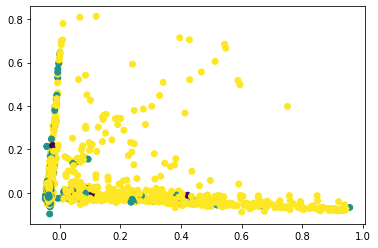

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(principalComponents[:,0], principalComponents[:,1],c=y.iloc[:,0])
plt.show()

In [ ]:
n_neighbors=5
min_dist=0.1
n_components=100
metric='euclidean'

fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
u = fit.fit_transform(X)
u

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


array([[10.597611 ,  5.086376 ,  5.5458946, ...,  5.2894692,  5.098184 ,
         4.464638 ],
       [10.239374 ,  6.337206 ,  5.959945 , ...,  5.0059323,  5.0945506,
         4.648683 ],
       [10.003893 ,  4.3524218,  5.8778114, ...,  5.1110873,  5.207022 ,
         4.6951866],
       ...,
       [10.121962 ,  5.394614 ,  6.1219797, ...,  5.0906653,  5.0307317,
         4.5508385],
       [10.329429 ,  5.9562345,  5.50409  , ...,  5.0709543,  4.953932 ,
         4.664714 ],
       [10.010637 ,  5.4171934,  6.254768 , ...,  4.967881 ,  5.0145993,
         4.453535 ]], dtype=float32)

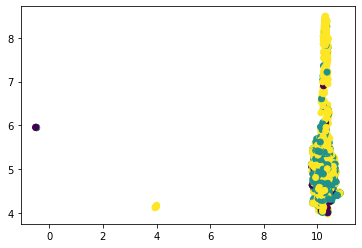

In [ ]:
plt.scatter(u[:,0], u[:,1],c=y.iloc[:,0])

In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X=df_combined.drop(['body','sentiment'],axis=1)
y=df_combined['sentiment']
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y, test_size = 0.30)

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(X_train, X_test, y_train.iloc[:,0], y_test.iloc[:,0])


100%|██████████| 29/29 [01:09<00:00,  2.40s/it]


In [ ]:
print(models)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.58               0.54    None      0.62   
LogisticRegression                 0.69               0.49    None      0.67   
LinearDiscriminantAnalysis         0.68               0.49    None      0.66   
LGBMClassifier                     0.68               0.49    None      0.66   
CalibratedClassifierCV             0.69               0.49    None      0.67   
LinearSVC                          0.69               0.49    None      0.66   
RidgeClassifierCV                  0.68               0.48    None      0.66   
RidgeClassifier                    0.68               0.48    None      0.66   
RandomForestClassifier             0.68               0.48    None      0.66   
XGBClassifier                      0.68               0.48    None      0.66   
SVC                                0.67 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(u, y, test_size = 0.30)

In [ ]:
clfu = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric = None)
modelsu,predictionsu = clfu.fit(X_train, X_test, y_train.iloc[:,0], y_test.iloc[:,0])


  3%|▎         | 1/29 [00:02<01:18,  2.80s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6017000607164542, 'Balanced Accuracy': 0.4402930402930403, 'ROC AUC': None, 'F1 Score': 0.5855804378951506, 'Time taken': 2.796555519104004}


  7%|▋         | 2/29 [00:06<01:27,  3.24s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.6017000607164542, 'Balanced Accuracy': 0.4455013912641031, 'ROC AUC': None, 'F1 Score': 0.5900410243054292, 'Time taken': 3.5571296215057373}
{'Model': 'BernoulliNB', 'Accuracy': 0.5397692774741955, 'Balanced Accuracy': 0.49732753122583634, 'ROC AUC': None, 'F1 Score': 0.560847356484847, 'Time taken': 0.05628538131713867}


 14%|█▍        | 4/29 [00:20<02:21,  5.67s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.6320582877959927, 'Balanced Accuracy': 0.4516398855381906, 'ROC AUC': None, 'F1 Score': 0.6087738110654319, 'Time taken': 14.162200927734375}


 21%|██        | 6/29 [00:21<01:12,  3.15s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.5561627200971463, 'Balanced Accuracy': 0.4466324635816161, 'ROC AUC': None, 'F1 Score': 0.5593416708834228, 'Time taken': 0.6378545761108398}
{'Model': 'DummyClassifier', 'Accuracy': 0.4304796599878567, 'Balanced Accuracy': 0.33612602087178356, 'ROC AUC': None, 'F1 Score': 0.4301493357485869, 'Time taken': 0.0319514274597168}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.5446265938069217, 'Balanced Accuracy': 0.42801266530080095, 'ROC AUC': None, 'F1 Score': 0.5461830308125104, 'Time taken': 0.04043078422546387}


 31%|███       | 9/29 [00:22<00:35,  1.79s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.607164541590771, 'Balanced Accuracy': 0.46233201826422166, 'ROC AUC': None, 'F1 Score': 0.5981273174971187, 'Time taken': 1.263000249862671}
{'Model': 'GaussianNB', 'Accuracy': 0.5470552519732848, 'Balanced Accuracy': 0.45306162763789876, 'ROC AUC': None, 'F1 Score': 0.5525488258707496, 'Time taken': 0.03840160369873047}


 38%|███▊      | 11/29 [00:23<00:24,  1.34s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.6114146933819065, 'Balanced Accuracy': 0.462788623805573, 'ROC AUC': None, 'F1 Score': 0.6043274555618101, 'Time taken': 0.782212495803833}


 41%|████▏     | 12/29 [00:57<02:05,  7.41s/it]

{'Model': 'LabelPropagation', 'Accuracy': 0.46569520340012144, 'Balanced Accuracy': 0.3333333333333333, 'ROC AUC': None, 'F1 Score': 0.29593058907033404, 'Time taken': 33.6358757019043}


 48%|████▊     | 14/29 [00:58<01:12,  4.80s/it]

{'Model': 'LabelSpreading', 'Accuracy': 0.591378263509411, 'Balanced Accuracy': 0.42253226998989707, 'ROC AUC': None, 'F1 Score': 0.5702562170114407, 'Time taken': 1.6996281147003174}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.6035215543412265, 'Balanced Accuracy': 0.4519948977576096, 'ROC AUC': None, 'F1 Score': 0.5915714744822809, 'Time taken': 0.17499208450317383}


 52%|█████▏    | 15/29 [01:02<01:03,  4.54s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.6265938069216758, 'Balanced Accuracy': 0.4477488613081833, 'ROC AUC': None, 'F1 Score': 0.6029495000124097, 'Time taken': 3.7302086353302}


 62%|██████▏   | 18/29 [01:03<00:21,  1.99s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.6217364905889496, 'Balanced Accuracy': 0.44425348662636804, 'ROC AUC': None, 'F1 Score': 0.5991167437095037, 'Time taken': 0.39449596405029297}
{'Model': 'NearestCentroid', 'Accuracy': 0.48633879781420764, 'Balanced Accuracy': 0.49811883032222015, 'ROC AUC': None, 'F1 Score': 0.5226511227887874, 'Time taken': 0.05615234375}


 72%|███████▏  | 21/29 [01:03<00:07,  1.03it/s]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.5063752276867031, 'Balanced Accuracy': 0.42663776901065037, 'ROC AUC': None, 'F1 Score': 0.5200464019209101, 'Time taken': 0.11253643035888672}
{'Model': 'Perceptron', 'Accuracy': 0.46690953248330297, 'Balanced Accuracy': 0.38809777792828637, 'ROC AUC': None, 'F1 Score': 0.4730586887560386, 'Time taken': 0.08917999267578125}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.4820886460230723, 'Balanced Accuracy': 0.4716848123627784, 'ROC AUC': None, 'F1 Score': 0.52852121338359, 'Time taken': 0.10148334503173828}


 79%|███████▉  | 23/29 [01:07<00:07,  1.22s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.6217364905889496, 'Balanced Accuracy': 0.4545838342448512, 'ROC AUC': None, 'F1 Score': 0.6072929061429798, 'Time taken': 3.6416664123535156}
{'Model': 'RidgeClassifier', 'Accuracy': 0.6253794778384942, 'Balanced Accuracy': 0.4468779807762859, 'ROC AUC': None, 'F1 Score': 0.6019319957846619, 'Time taken': 0.13229584693908691}


 83%|████████▎ | 24/29 [01:07<00:04,  1.05it/s]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.6205221615057681, 'Balanced Accuracy': 0.4433961518707281, 'ROC AUC': None, 'F1 Score': 0.5976418634614745, 'Time taken': 0.17987537384033203}


 86%|████████▌ | 25/29 [01:07<00:03,  1.26it/s]

{'Model': 'SGDClassifier', 'Accuracy': 0.5792349726775956, 'Balanced Accuracy': 0.42423508694695133, 'ROC AUC': None, 'F1 Score': 0.5637360947394974, 'Time taken': 0.354780912399292}


 90%|████████▉ | 26/29 [01:11<00:04,  1.55s/it]

{'Model': 'SVC', 'Accuracy': 0.6290224650880388, 'Balanced Accuracy': 0.44948215626181726, 'ROC AUC': None, 'F1 Score': 0.6052094516107225, 'Time taken': 3.5030980110168457}


 97%|█████████▋| 28/29 [01:18<00:02,  2.43s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.6193078324225865, 'Balanced Accuracy': 0.4554242367801689, 'ROC AUC': None, 'F1 Score': 0.6065958339424413, 'Time taken': 7.078643560409546}


100%|██████████| 29/29 [01:21<00:00,  2.80s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.6272009714632666, 'Balanced Accuracy': 0.46627553237722724, 'ROC AUC': None, 'F1 Score': 0.6141445804030831, 'Time taken': 2.8317699432373047}


In [ ]:
print(modelsu)

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
NearestCentroid                    0.49               0.50    None      0.52   
BernoulliNB                        0.54               0.50    None      0.56   
QuadraticDiscriminantAnalysis      0.48               0.47    None      0.53   
LGBMClassifier                     0.63               0.47    None      0.61   
KNeighborsClassifier               0.61               0.46    None      0.60   
ExtraTreesClassifier               0.61               0.46    None      0.60   
XGBClassifier                      0.62               0.46    None      0.61   
RandomForestClassifier             0.62               0.45    None      0.61   
GaussianNB                         0.55               0.45    None      0.55   
LinearDiscriminantAnalysis         0.60               0.45    None      0.59   
CalibratedClassifierCV             0.63 

In [ ]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

clsflrpf = Perceptron()
clsflrpf.partial_fit(X_train, y_train.iloc[:,0], classes=np.unique(y.iloc[:,0]))
predictclflrpf=clsflrpf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test.iloc[:,0], predictclflrpf))


Accuracy: 0.45658773527625984


In [ ]:
y_train.iloc[:,0].value_counts()

 0    1851
 1    1738
-1     253
Name: sentiment, dtype: int64